<a href="https://colab.research.google.com/github/MamadouBousso/Transformers-for-Natural-Language-Processing/blob/main/UrgencyvsNonUrgencyPytorchTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapes pour resoudre le probleme de classification des voitures d'urgence et de non urgence

<ol>1. Charger les données</ol>
<ol>2. Pre-traitement des donnees</ol>
<ol>3. Creer les ensembles de train et validation</ol>
<ol>4. Definir les modeles d'architecture</ol>
<ol>5. Compiler le modele</ol>
<ol>6. Entrainer le modele</ol>
<ol>7. Evaluer les performances du modele</ol>

## Reseau de neurones convoles

### Charger le modele

In [ ]:

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import torch
import sys
from torch import nn as nn
import torch.optim as optim


import torch.nn.functional as F
import datetime
from torch.utils.data import TensorDataset, DataLoader,random_split,WeightedRandomSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as tf


from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datapath = '/content/drive/MyDrive/ImageClassification2022/Neuralnetwork/'

In [ ]:
sys.path.append(datapath)

In [ ]:
!unzip /content/drive/MyDrive/ImageClassification2022/Neuralnetwork/Dataset.zip

Archive:  /content/drive/MyDrive/ImageClassification2022/Neuralnetwork/Dataset.zip
replace Dataset/emergency_classification.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# lecture du fichier csv
data = pd.read_csv('Dataset/emergency_classification.csv')

In [ ]:
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [ ]:
# choix d'un generateur aleatoire
seed = 32
rng = np.random.RandomState(seed)

In [ ]:
data['emergency_or_not'].value_counts()

0    1361
1     991
Name: emergency_or_not, dtype: int64

Visualisons quelques images

In [ ]:
import skimage
from skimage.io import imread, imshow, imsave


In [ ]:
def visualiser_image2(data: pd.DataFrame,num: int,diviseur:int)->None:
  
  list_images = []
  labels = []
  # Recuperer un echantillon de nom d'images et leurs classes
  df_elem = data.sample(n=num)
  for name_img in df_elem.image_names:
    # Lire les images à partir de leurs noms et les ajouter dans une liste
    im = imread('Dataset/images/'+name_img)
    list_images.append(im)
  labels = list(df_elem.emergency_or_not)
  # Transgormer la liste en array
  list_images = np.array(list_images)
  # Faire la visualisation sous forme de grille des images
  fig, ax = plt.subplots(diviseur,diviseur,figsize = (10,10))
  for i in range(num ):
    
    ax[i//diviseur,i%diviseur].imshow(list_images[i])
    ax[i//diviseur,i%diviseur].set_title(f"Classe {labels[i]}")

Error in callback <function _draw_all_if_interactive at 0x7f55dc5e5000> (for post_execute):


KeyboardInterrupt: ignored

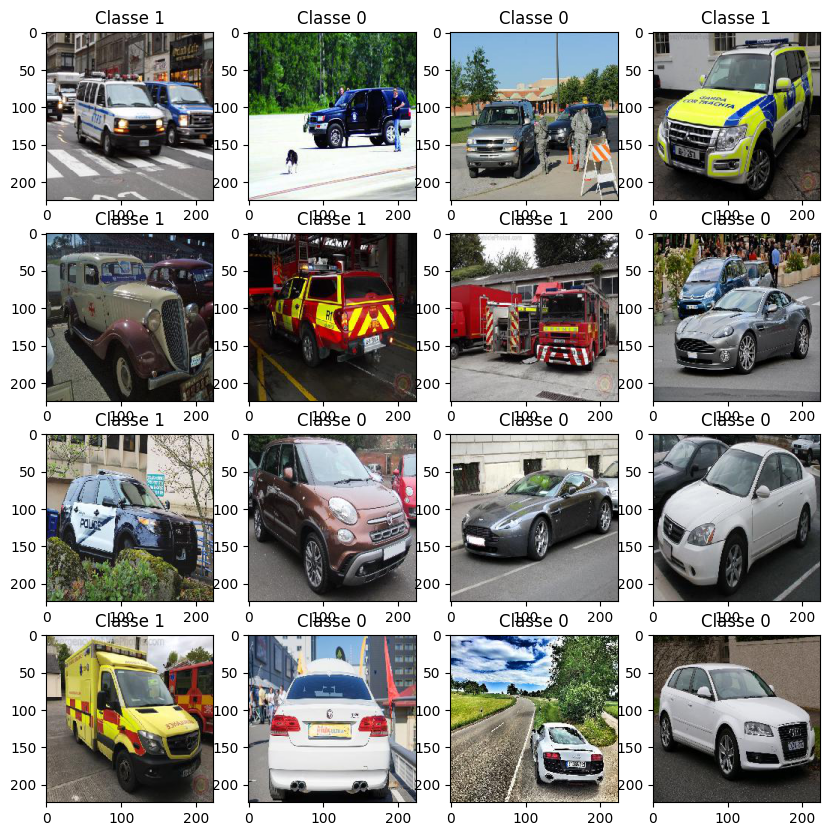

In [ ]:
visualiser_image2(data,16,4)

In [ ]:
list_images = []
labels = []
# Recuperer les noms des images et leurs classes
for img in data.image_names:
  im = imread('Dataset/images/'+img)
  list_images.append(im)
labels = list(data.emergency_or_not)
# Les mettre dans un tableau numpy
list_images = np.array(list_images)

In [ ]:
labels = np.array(labels)


In [ ]:
images_tens = torch.as_tensor(list_images/255).float()
labels_tens = torch.as_tensor(labels.reshape(-1,1)).float()
images_tens.shape

torch.Size([2352, 224, 224, 3])

In [ ]:
images_tens = images_tens.permute(0,3,1,2)

In [ ]:
def split_data(n,splits, seed = 13):
  """"
  Cree des ensembles d'indices suivant le decoupage proposé dans la liste splits
  """
  # Les indices de toutes les données
  idx = torch.arange(n)
  # On cherche un multiplicateur par rapport à l'intervalle de division
  multiplier = n/sum(splits)
  # Nouvel intervalle adapte à la taille des données. On aura le nombre d'indices pour chaque sous-ensemble
  new_splits = torch.as_tensor([i*multiplier for i in splits]).long()
  
  # Difference eventuelle entre la taille des données et la somme des nombres d'elements des sous-ensembles
  diff = n - new_splits.sum()
  # S'il y a difference, ajouter cette difference au premier element de l'intervalle
  new_splits[0] += diff
  # Retourne les indices sélectionnés chaque sous-ensemble
  # Utiliser random_split de pytorch
  torch.manual_seed(seed)
  return random_split(idx,new_splits)

### Preparation des données

In [ ]:
class TransformedTensorDataset(TensorDataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
                
    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
            x = self.transform(x)
            
        return x, self.y[index]
            
    def __len__(self):
        return len(self.x)

# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
#x_tensor = torch.as_tensor(images / 255).float()
#y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx =  split_data(2352,[80,20], seed = 13)
# Uses indices to perform the split
x_train_tensor = images_tens[train_idx]
y_train_tensor = labels[train_idx]
x_val_tensor = images_tens[val_idx]
y_val_tensor = labels[val_idx]

# We're not doing any data augmentation now
train_composer = tf.Compose([tf.Normalize(mean=(.5,), std=(.5,)),
        
        tf.RandomRotation(30)])
val_composer = tf.Compose([tf.Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
#sampler = SubsetRandomSampler(train_idx)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [ ]:
x,y = next(iter(train_loader))

In [ ]:
x.shape

torch.Size([16, 3, 224, 224])

In [ ]:
x = x.permute(0,3,1,2)

In [ ]:
x.shape

torch.Size([16, 224, 3, 224])

### Patches

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

In [ ]:
import torchvision
img_patches = img_to_patch(x, patch_size=8, flatten_channels=True)
print(img_patches.shape)
fig, ax = plt.subplots(x.shape[0], 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(x.shape[0]):
    print(img_patches[i].shape)
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

RuntimeError: ignored

In [ ]:
# Adapted from https://discuss.pytorch.org/t/tf-extract-image-
# patches-in-pytorch/43837
def extract_image_patches(x, kernel_size, stride=1):
  # Extract patches
  patches = x.unfold(2, kernel_size, stride)
  patches = patches.unfold(3, kernel_size, stride)
  patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
  return patches.view(x.shape[0], patches.shape[1], patches.shape[2], -1)

In [ ]:
kernel_size = 2
patches = extract_image_patches(
  x, kernel_size, stride=kernel_size
)
print(patches.shape)



torch.Size([16, 1, 112, 896])


In [ ]:

def plot_patches(patches, kernel_size=3):
    n, p1, p2, v = patches.shape
    fig, axs = plt.subplots(p1, p2, figsize=(3, 3))
    for i in range(p1):
        for j in range(p2):
            axs[i, j].imshow(patches.squeeze()[i, j].view(kernel_size, -1).cpu().detach().numpy(), cmap=plt.cm.gray)
            axs[i, j].grid(False)
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
    return fig

def plot_seq_patches(seq_patches):
    seq_patches = seq_patches.cpu().detach().numpy()
    fig, axs = plt.subplots(1, seq_patches.shape[0], figsize=(10, 10))
    for i in range(seq_patches.shape[0]):
        axs[i].imshow(seq_patches[i].reshape(-1, 1), cmap=plt.cm.gray)
        axs[i].grid(False)
        axs[i].set_xticklabels([])
        axs[i].set_xlabel(i)
        axs[i].set_ylabel('Features')
        axs[i].label_outer()
    fig.suptitle('Sequence')
    fig.tight_layout(pad=0.7)
    fig.subplots_adjust(top=0.9)
    return fig

def plot_seq_patches_transp(seq_patches, add_cls=False, title=None):
    seq_patches = seq_patches.cpu().detach().numpy()
    seq_patches = np.atleast_3d(seq_patches)
    n, l, d = seq_patches.shape
    fig, saxs = plt.subplots(1+seq_patches.shape[1]+add_cls, n, figsize=(n*6, 6), sharex=True)
    
    if title is None:
        title = 'Sequence'
    for seq_n in range(n):
        axs = saxs[:, seq_n]
        if add_cls:
            sub_patches = np.concatenate([np.zeros_like(seq_patches[seq_n, :1]), seq_patches[seq_n]])
        else:
            sub_patches = seq_patches[seq_n]
        axs[0].text(4, 1, f'{title} #{seq_n}', fontsize=16)
        axs[0].grid(False)
        axs[0].set_yticks([])
        for i in range(sub_patches.shape[0]):
            label = i
            if add_cls:
                label = i-1 if i > 0 else '[CLS]'
            axs[i+1].imshow(sub_patches[i].reshape(1, -1), cmap=plt.cm.gray)
            axs[i+1].set_yticklabels([label], rotation=0)
            axs[i+1].grid(False)
            axs[i+1].set_yticks([0])
            #axs[i+1].set_ylabel(i, rotation=0)
            #axs[i+1].label_outer()
        axs[-1].set_xlabel('Features')
    fig.tight_layout()
    return fig

IndexError: ignored

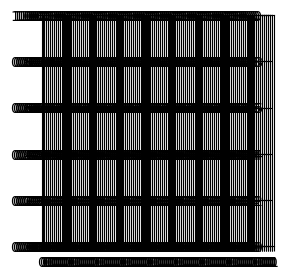

In [ ]:
fig = plot_patches(patches,4)

In [ ]:
# Adapted from https://amaarora.github.io/2021/01/18/ViT.html
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, dilation=1):
        super().__init__()        
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1,2)
        return x

In [ ]:
x.shape
x = x.permute(0,2,1,3)

NameError: ignored

In [ ]:
torch.manual_seed(13)
patch_embed = PatchEmbed(x.size(-1), 8, 3, 8**2)
embedded = patch_embed(x)
embedded.shape

In [ ]:
plot_seq_patches_transp(embedded[1])

## Model

In [ ]:
class ViT(nn.Module):
    def __init__(self, encoder, img_size, in_channels, patch_size, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(encoder.d_model, n_outputs)

        self.embed = PatchEmbed(img_size, patch_size, in_channels, encoder.d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, encoder.d_model))
        
    def preprocess(self, X):
        # Patch embeddings
        # N, L, F -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        
        return src
    
    def encode(self, source):
        # Encoder generates "hidden states"
        states = self.encoder(source)
        # Gets state from first token: CLS
        cls_state = states[:, 0]  # N, 1, D
        return cls_state
        
    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src)
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

### Model Configuration

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # transformations affine pour Q, K, et V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        """
            Fonction d'initialisation des cles et valeurs pour chaque nouveau query
            Recoit une sequence batch-first d'etats cachés de l'encodeur
            
            Elles sont calculées une seule fois au debut et utilisées plusieurs fois
            
        """
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # produit scalaire standardisé
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        #  Calcul du produit scalaire standardise
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Requete sous la forme batch-first N, 1, H
        #  Calcul des scores d'alignment
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        #  Calcul des scores d'attention
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        #  Calcul des vecteurs de contexte
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

In [ ]:
class MultiHeadAttentionFirst(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        # ModuleList de pytorch permet de creer une liste de modeles et d'iterer dessus.
        # Ce que pytorch ne permet pas avec les listes classiques de python
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Dimensions: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        # Linear transf. pour retourner aux dimensions originales
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

In [ ]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttentionFirst(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.3):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k) 
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)  
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))
        
    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, 
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas =  F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()
        
        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context        
                                
    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out
        
    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # dimensions paires
        pe[:, 1::2] = torch.cos(position * angular_speed) # dimensions impaires
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x est N, L, D
        # pe est 1, maxlen, D
        
        scaled_x = x * np.sqrt(self.d_model)
      
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out


In [ ]:
class StepByStep(object):
  """
  Cette classe permet de faire le training du modele
  """
  def __init__(self, model, optimiseur,loss_fn):
    """Doit être initialisé avec les arguments necessaires eu training 
    à savoir: le modele, l'optimiseur et la fonction perte.
    Nous aurons besoins de lui passer les loaders de données et le writer pour interfacer avec Tensorboard

    Nous devons à nouveau ajouter le code suivant à la méthode du constructeur (comme
    nous avons fait avec les loaders)
    """
    self.model = model
    self.optimiseur = optimiseur
    self.loss_fn = loss_fn

    # Attribuer le device au model
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.model.to(self.device)
    # Les loaders 
    self.train_dl = None
    self.val_dl = None
    self.writer =  None

    # Les variables
    self.epochs = 0
    
    self.loss = []
    self.val_loss = []
    # Fonctions permettant de faire le train

    self.train_step = self._make_train_step()
    self.val_step = self._make_eval_step()

  def to(self,device):
    """
    Permet de changer le device du model
    """
    self.device  = device
    self.model.to(self.device)

  def set_loaders(self,train_dl,val_dl = None):
    """
    Permet de modifier les dataloaders
    """
    self.train_dl = train_dl
    self.val_dl = val_dl

  def set_tensorboard(self,name,folder = 'runs'):
    """
    Permet de creer un SummaryWriter qui interface avec le tensorboard
    """
    suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    self.writer = SummaryWriter('{}/{}_{}'.format(folder, name, suffix))

  def _make_train_step(self):
    def training_model_pas(X,y):
    
      # Attention: permet juste de mettre le modéle en mode training et non en mode evalation. Par exemple le dropout n'est fait que durant 
      # le training
      self.model.train()

      # On n'appelle pas la methode froward() mais juste le modele
      y_hat_tens = self.model(X)
  
     
      
      loss_tens = self.loss_fn(y_hat_tens.squeeze(1) , y.float())
      

  

      loss_tens.backward()
  
      self.optimiseur.step()

  

    
      self.optimiseur.zero_grad()

      return loss_tens.tolist()

  
    
    return training_model_pas

  def _make_eval_step(self):
    def training_model_eval_pas(X,y):
    
      # Attention: permet juste de mettre le modéle en mode training et non en mode evalation. Par exemple le dropout n'est fait que durant 
      # le training
      self.model.eval()

      # On n'appelle pas la methode froward() mais juste le modele
      y_hat_tens = self.model(X)
  

    

      loss_tens = self.loss_fn(y_hat_tens.squeeze(1) , y.float())

  

      return loss_tens.tolist()

  
    
    return training_model_eval_pas

  def _mini_batch(self,validation = None):
    if validation != None:
      step = self.val_step
      loader = self.val_dl
    
    else:
      step = self.train_step
      loader = self.train_dl
    
    if loader is None:
      return None
  
    mini_batch_loss = []
    for x,y in loader:
      x = x.to(self.device)
      y = y.to(self.device)
      batch_loss = step(x,y)
      mini_batch_loss.append(batch_loss)
    return np.mean(mini_batch_loss)

  def train(self,n_epochs, seed = 42):
  
    torch.manual_seed(seed)

    #model = nn.Sequential(nn.Linear(1,1)).to(device)
    self.writer = SummaryWriter()
  
    for i in range(n_epochs):
  
      self.epochs += 1
      
      #print('ici')
      erreur_train = self._mini_batch()
      
      self.loss.append(erreur_train)
      
      with torch.no_grad():

        erreur_val = self._mini_batch(validation = True)

        self.val_loss.append(erreur_val)
        #print(erreur_train)
      if self.writer:
        scalars = {'training': erreur_train}
        if erreur_val is not None:
          scalars.update({'validation': erreur_val})
      # Records both losses for each epoch under tag "loss"
        self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars,global_step=i)
  
    if self.writer:
    # Flushes the writer
      self.writer.flush()

  def save_checkpoint(self,nom_fichier):
    """Permet de sauver le modele"""
    checkpoint = {
    'epoch':self.epochs,
    'model.state_dict': self.model.state_dict(),
    'optimiser.state_dict': self.optimiseur.state_dict(),
    'loss': self.loss,
    'val_loss':self.val_loss
    }
    torch.save(checkpoint,nom_fichier)

  def load_checkpoint(self, nom_fichier):
    """Permet de restaurer le modele"""
    checkpoint = torch.load(nom_fichier)
    self.model.load_state_dict(checkpoint['model.state_dict'])
    self.optimiseur.load_state_dict(checkpoint['optimiser.state_dict'])
    self.epochs = checkpoint['epoch']
    saved_loss = checkpoint['loss']
    saved_val_loss = checkpoint['val_loss']
    # Ne pas oublier de mettre le modele en mode train
    self.model.train()

  def make_prediction(self,x):
    """Faire une prediction à partir d'un tableau numpy"""
    # Mettre le modele en mode prediction
    self.model.eval()

    x_tensor = torch.as_tensor(x).float()

    y_hat = self.model(x_tensor.to(self.device))

    # Ramener le modele en training mode
    self.model.train()
    # Retourner sous forme de tableau numpy
    return y_hat.detach().cpu().numpy()

  def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.loss, label='Training Loss', c='b')
    if self.val_dl:
      plt.plot(self.val_loss, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

  def add_graph(self):
    if self.train_loader and self.writer:
      # Extraire un seul mini-batch et utiliser add_graph du writer
      x_dummy, y_dummy = next(iter(self.train_loader))
      self.writer.add_graph(self.model, x_dummy.to(self.device))




In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.3):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
         
    def forward(self, query, mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Multi-headed Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, mask)
        # Add
        att = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att = self.norm2(att)
        # Feed Forward
        out = self.ffn(norm_att)
        # Add
        out = att + self.drop2(out)
        return out

In [ ]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])
    
    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

## Training du modele

In [ ]:
torch.manual_seed(17)
layer = EncoderLayer(n_heads=4, d_model=16, ff_units=20)
encoder = EncoderTransf(layer, n_layers=4,max_len = 785)
model_vit = ViT(encoder, img_size=224, in_channels=3, patch_size=8, n_outputs=1)
multi_loss_fn =  nn.BCEWithLogitsLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=1e-3)


In [ ]:
sbs_vit = StepByStep(model_vit,  optimizer_vit, multi_loss_fn)
sbs_vit.set_loaders(train_loader, val_loader)
sbs_vit.train(20)

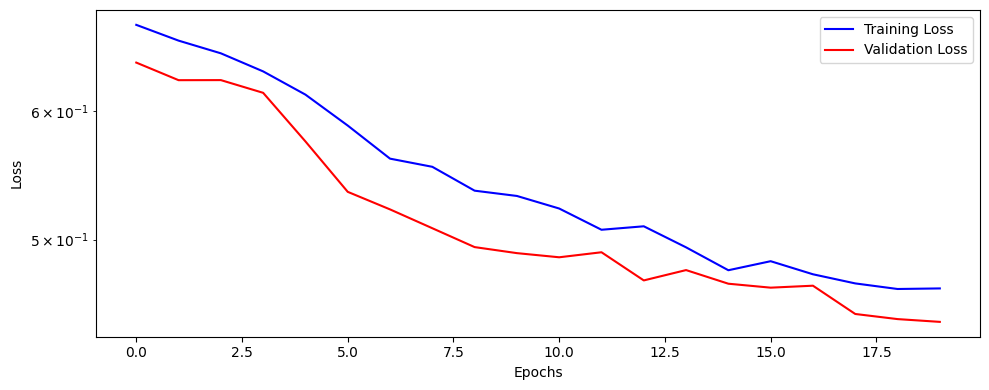

In [ ]:
fig = sbs_vit.plot_losses()

In [ ]:
x,y = next(iter(train_loader))

In [ ]:
x[0].shape

torch.Size([3, 224, 224])

In [ ]:
x[0].shape

torch.Size([3, 224, 224])

In [ ]:
yhat = sbs_vit.make_prediction(x)

In [ ]:
yhat.shape

(16, 1)

In [ ]:

yhat = torch.sigmoid(torch.tensor(yhat).detach())

In [ ]:
yhat

tensor([[0.3000],
        [0.1864],
        [0.9724],
        [0.2701],
        [0.6841],
        [0.9661],
        [0.2696],
        [0.2274],
        [0.1865],
        [0.1974],
        [0.1914],
        [0.5210],
        [0.0928],
        [0.1144],
        [0.1296],
        [0.6300]])

In [ ]:
y

tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
sbs_vit.save_checkpoint('savemodel.pth')